# How do the different parameterization options affect the population level radius?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import cbmos_serial as cbmos
import force_functions as ff
import euler_forward as ef
import adams_bashforth as ab
import midpoint as md
import heun as he
import cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6.75, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

In [3]:
# calculate radius
def calculate_radius(cell_list):
    n_cells = len(cell_list)
    positions = np.array([cell.position for cell in cell_list])
    c = np.sum(positions, axis=0)/n_cells
    return 0.5 + max([np.linalg.norm(cell.position - c) for cell in cell_list])

In [4]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
dim = 2
seed=67
t_data = np.linspace(0, tf, int(100*tf)+1)
n = 20

In [5]:
solver_names = ['EF', 'AB', 'midpoint', 'Heun']
force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[1], 'GLS': defcolors[2]}


In [6]:
# Solvers
solvers_scpi = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, scpi.solve_ivp, dim), 
             'cubic': cbmos.CBMSolver(ff.cubic, scpi.solve_ivp, dim),
             'GLS': cbmos.CBMSolver(ff.gls, scpi.solve_ivp, dim)}




## Initial condition

In [7]:
# 2D honeycomb mesh
n_x = 5
n_y = 5
xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

# make cell_list for the sheet
initial_sheet = [cl.Cell(i, [x,y], -24.0, True, lambda t: 24+t) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]
# delete cells to make it circular
del initial_sheet[24]
del initial_sheet[20]
del initial_sheet[19]
del initial_sheet[9]
del initial_sheet[4]
del initial_sheet[0]

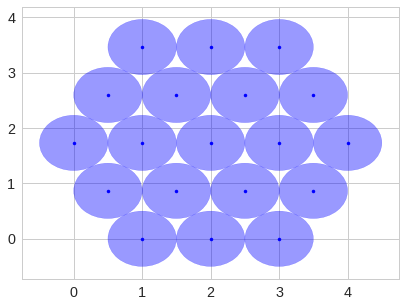

In [8]:
# plot to check what happend
plot_population(initial_sheet)

In [9]:
#prepare consistent initial data
solver_scipy = cbmos.CBMSolver(ff.piecewise_polynomial, scpi.solve_ivp, dim)
#solver_scipy = cbmos.CBMSolver(ff.cubic, scpi.solve_ivp, dim)
t_data_init = [0, 0.00001]
#initial_sheet = solver_scipy.simulate(sheet, t_data_init, {"mu": 5.70, "s": s, "rA": rA}, {}, seed=seed)[-1]
sheet = solver_scipy.simulate(initial_sheet, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=seed)[-1]




len(initial_sheet)

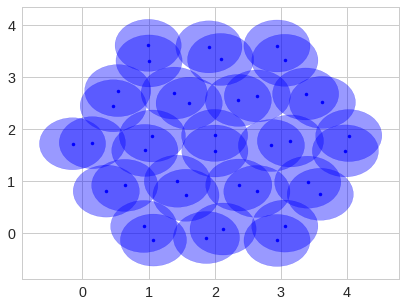

In [10]:
# plot to check what happend
plot_population(sheet)

## 1. Fitted according to relaxation time

In [11]:
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

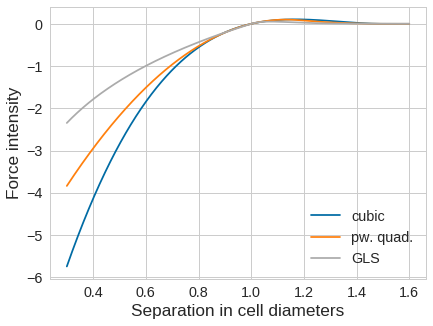

In [12]:
r_val = np.linspace(0.3, 1.6, 1001)
plt.plot(r_val, ff.cubic(r_val, **params_cubic), label='cubic')
plt.plot(r_val, ff.piecewise_polynomial(r_val, **params_poly), label='pw. quad.')
plt.plot(r_val, ff.gls(r_val, **params_gls), label='GLS')
plt.xlabel('Separation in cell diameters')
plt.ylabel('Force intensity')
plt.legend()
plt.savefig('plot_gls_cubic_pw_quad_lr.pdf', bbox_inches='tight')

In [13]:
radii = {'cubic': np.zeros(len(t_data)), 'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a)[-1]
      
    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params[force], {}, seed=a)
        radii[force] = radii[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii[force] = radii[force]/n

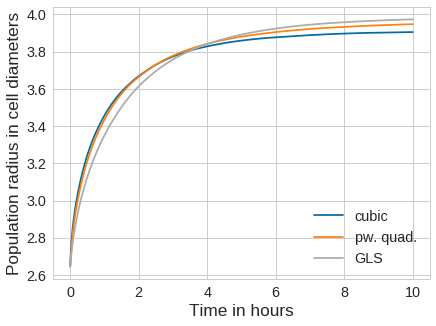

In [14]:
for force in force_names: 
    plt.plot(t_data, np.squeeze(radii[force]), label=force, color=colors[force])
#plt.plot(t_data, 4.0*np.ones(len(t_data)), color='grey')

plt.ylabel('Population radius in cell diameters')

plt.xlabel('Time in hours')
plt.legend()
plt.savefig('radius_fit_relaxation_time.pdf', bbox_inches='tight')

We now take the cubic force law as a basis to compare with.

In [15]:
radii_cubic = radii['cubic']

In [16]:
force_names = ['pw. quad.', 'GLS']

## 2. Fitted according to force shape

### 2.1 Over the repulsive range

In [17]:
muR = 1.13496715e+01
ratio = 1.79125464e-03
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 4.27
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

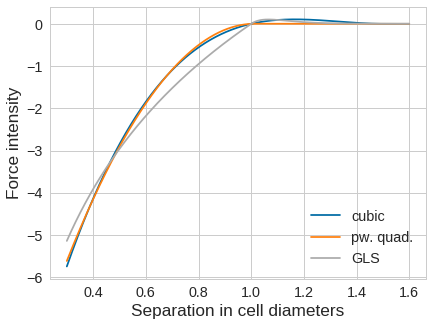

In [18]:
r_val = np.linspace(0.3, 1.6, 1001)
plt.plot(r_val, ff.cubic(r_val, **params_cubic), label='cubic')
plt.plot(r_val, ff.piecewise_polynomial(r_val, **params_poly), label='pw. quad.')
plt.plot(r_val, ff.gls(r_val, **params_gls), label='GLS')
plt.xlabel('Separation in cell diameters')
plt.ylabel('Force intensity')
plt.legend()
plt.savefig('plot_gls_cubic_pw_quad_rr.pdf', bbox_inches='tight')

If you only plot it for r_val=np.linspace(0.8, 1.6, 1001) the fit between GLS and the others looks really bad.

In [19]:
radii = { 'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a)[-1]

    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params[force], {} , seed=a)
        radii[force] = radii[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii[force] = radii[force]/n

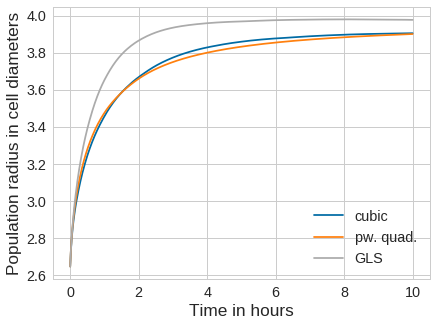

In [20]:
plt.plot(t_data, radii_cubic, label='cubic', color=colors['cubic'])
for force in force_names: 
    plt.plot(t_data, np.squeeze(radii[force]), label=force, color=colors[force])
#plt.plot(t_data, 4.0*np.ones(len(t_data)), color='grey')
plt.ylabel('Population radius in cell diameters')

plt.xlabel('Time in hours')
plt.legend()
plt.savefig('radius_fit_repulsive_range.pdf', bbox_inches='tight')

The large discrepancy between GLS and the other two might be an argument for fitting the parameters such that the radius agrees.

### 2.2 Over the complete range

In [21]:
muR = 1.13328915e+01
ratio = 2.14391581e-03
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 4.27
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

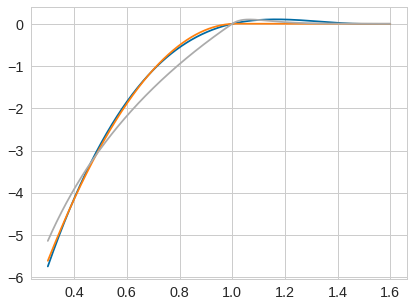

In [22]:
r_val = np.linspace(0.3, 1.6, 1001)
plt.plot(r_val, ff.cubic(r_val, **params_cubic))
plt.plot(r_val, ff.piecewise_polynomial(r_val, **params_poly))
plt.plot(r_val, ff.gls(r_val, **params_gls))


If you only plot it for r_val=np.linspace(0.8, 1.6, 1001) the fit between GLS and the others looks really bad.

In [23]:
radii = { 'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data))}
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a)[-1]
    
    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params[force], {}, seed=a)
        radii[force] = radii[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii[force] = radii[force]/n

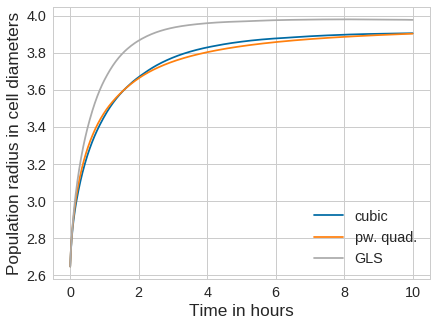

In [24]:
plt.plot(t_data, radii_cubic, label='cubic', color=colors['cubic'])
for force in force_names: 
    plt.plot(t_data, np.squeeze(radii[force]), label=force, color=colors[force])
#plt.plot(t_data, 4.0*np.ones(len(t_data)), color='grey')
plt.ylabel('Population radius in cell diameters')

plt.xlabel('Time in hours')
plt.legend()
#plt.savefig('radius_sensitivity_timestep.pdf', bbox_inches='tight')

Now the difference between PWQ and cubic is slightly larger.

### 2.3 Over the adhesive range

In [25]:
muR = 8.13262893
ratio = 0.46188714
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 4.43
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

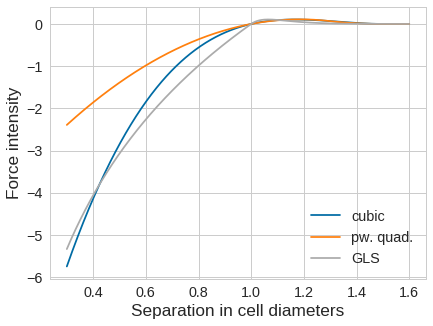

In [26]:
r_val = np.linspace(0.3, 1.6, 1001)
plt.plot(r_val, ff.cubic(r_val, **params_cubic), label='cubic')
plt.plot(r_val, ff.piecewise_polynomial(r_val, **params_poly), label='pw. quad.')
plt.plot(r_val, ff.gls(r_val, **params_gls), label='GLS')
plt.xlabel('Separation in cell diameters')
plt.ylabel('Force intensity')
plt.legend()
plt.savefig('plot_gls_cubic_pw_quad_ar.pdf', bbox_inches='tight')

In [27]:
radii = {'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data))}
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a)[-1]

    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params[force], {}, seed=a)
        radii[force] = radii[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii[force] = radii[force]/n

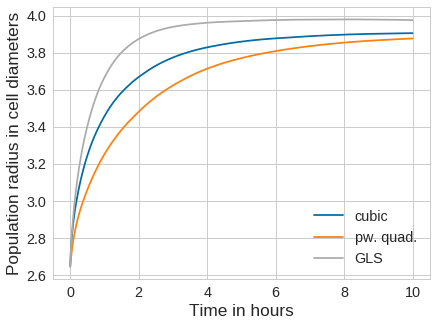

In [28]:
plt.plot(t_data, radii_cubic, label='cubic', color=colors['cubic'])
for force in force_names: 
    plt.plot(t_data, np.squeeze(radii[force]), label=force, color=colors[force])
#plt.plot(t_data, 4.0*np.ones(len(t_data)), color='grey')
plt.ylabel('Population radius in cell diameters')

plt.xlabel('Time in hours')
plt.legend()
plt.savefig('radius_fit_adhesive_range.pdf', bbox_inches='tight')

The limit should be between $2*sqrt(3)\approx 4.0$ and 4.5

## Fit them st. population radius dynamics agree

In [29]:
#n = 10
#def opt_GLS(mu):
#    radii = np.zeros(len(t_data))
#    for a in range(0,n):
#        history = solvers_scpi['GLS'].simulate(sheet, t_data, {'mu': mu, 'a':-2*np.log(0.002/mu)}, {}, seed=a)
#        radii = radii + np.array([calculate_radius(cl) for cl in history])
#    radii = radii/n
#    return np.linalg.norm(radii - radii_cubic)

#opt_GLS_mu = minimize(opt_GLS, 1.0, method='BFGS', options={'gtol': 1e-5, 'disp': True})

In [30]:
#opt_GLS_mu.x

In [31]:
#n = 10
#def opt_PWQ(p):
#    muR = p[0]
#    ratio = p[1]
#    radii = np.zeros(len(t_data))
#    for a in range(0,n):
#        history = solvers_scpi['pw. quad.'].simulate(sheet, t_data, {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a)
#        radii = radii + np.array([calculate_radius(cl) for cl in history])
#    radii = radii/n
#    return np.linalg.norm(radii - radii_cubic)

#opt_PWQ_mu = minimize(opt_PWQ, [10.0, 0.5], method='L-BFGS-B', bounds=((0, None),(0, None)), options={'gtol': 1e-5, 'disp': True})

In [32]:
#opt_PWQ_mu.x

In [33]:
#opt_PWQ_mu.fun

In [34]:
muR = 9.76
ratio = 0.26
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 2.28
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

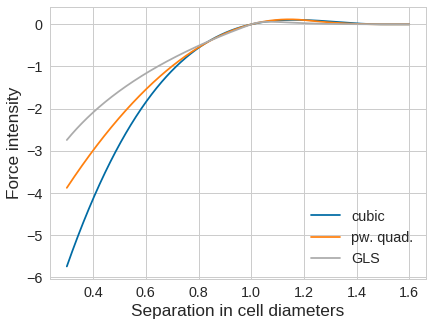

In [35]:
r_val = np.linspace(0.3, 1.6, 1001)
plt.plot(r_val, ff.cubic(r_val, **params_cubic), label='cubic')
plt.plot(r_val, ff.piecewise_polynomial(r_val, **params_poly), label='pw. quad.')
plt.plot(r_val, ff.gls(r_val, **params_gls), label='GLS')
plt.xlabel('Separation in cell diameters')
plt.ylabel('Force intensity')
plt.legend()
plt.savefig('plot_gls_cubic_pw_quad_pr.pdf', bbox_inches='tight')

In [36]:
radii = {'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data))}
n=20
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a)[-1]

    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params[force], {}, seed=a)
        radii[force] = radii[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii[force] = radii[force]/n

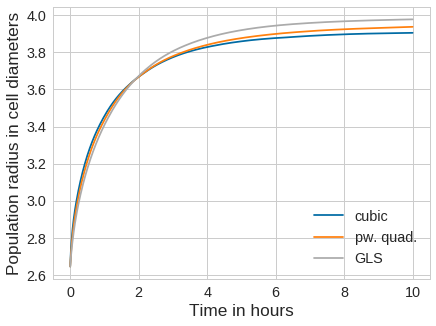

In [37]:
plt.plot(t_data, radii_cubic, label='cubic', color=colors['cubic'])
for force in force_names: 
    plt.plot(t_data, np.squeeze(radii[force]), label=force, color=colors[force])
#plt.plot(t_data, 4.0*np.ones(len(t_data)), color='grey')
plt.ylabel('Population radius in cell diameters')

plt.xlabel('Time in hours')
plt.legend()
plt.savefig('radius_fit_population_radius.pdf', bbox_inches='tight')